In [63]:
import torch
from torch import nn
from dataclasses import dataclass
from pathlib import Path
import requests
import unicodedata
import json
from collections import Counter, defaultdict
import base64
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import requests
import unicodedata
import json
from collections import Counter, defaultdict
import base64

from IPython.display import Image, display
import torch
import numpy as np
from jaxtyping import Int, Float
import matplotlib.pyplot as plt

In [47]:
@dataclass
class Config:
    d_model:int
    d_vocab:int
    d_hidden:int

In [48]:
def get_gutenberg_book(
	id: int|None = 84,
	data_temp: Path|str = "../data/gutenberg_data",
	remove_gutenberg_meta: bool = True,
) -> str:
	
	data_temp = Path(data_temp)
	data_temp.mkdir(parents=True, exist_ok=True)
	
	url: str = f"https://www.gutenberg.org/cache/epub/{id}/pg{id}.txt"
	data_path: Path = Path(data_temp) / f"{id}.txt"
	data: str
	# read from cache if it exists
	if data_path.exists():
		with open(data_path, 'r', encoding='utf-8') as file:
			data = file.read()
	else:
		# download if it doesn't exist
		response = requests.get(url)
		response.raise_for_status()  # Ensure that the download was successful
		data = response.text

		# save to cache
		with open(data_path, 'w', encoding='utf-8') as file:
			file.write(data)

	# remove header/footer
	if remove_gutenberg_meta:
		data = '***'.join(data.split('***')[2:])
		data = '***'.join(data.split('***')[:-1])
	
	return data

def get_many_books(
		ids: list[int],
		data_temp: Path|str = "../data/gutenberg_data",
	) -> list[str]:
	
	data: list[str] = []
	for id in ids:
		print(f"Getting book {id}...")
		item: str = get_gutenberg_book(id, data_temp)
		print(f"\t{len(item)} characters read")
		data.append(item)
	
	return data

In [49]:
DATA_RAW: list[str] = get_many_books([84, 15, 18, 82, 996, 2600])

print(f"{sum(len(x) for x in DATA_RAW) = }")

Getting book 84...
	426785 characters read
Getting book 15...
	1261231 characters read
Getting book 18...
	1192778 characters read
Getting book 82...
	1124986 characters read
Getting book 996...
	2342262 characters read
Getting book 2600...
	3273998 characters read
sum(len(x) for x in DATA_RAW) = 9622040


In [65]:
def process_text(
	text: str,
	allowed_punctuation: str = "-.,;:!?()\"" + "".join(str(x) for x in range(10)),
	punctuation_convert: dict[str,str] = {'—': '-'},
) -> str:
	
	# replace some special characters which unicode won't normalize properly
	for char, replacement in punctuation_convert.items():
		text = text.replace(char, replacement)

	# if a line has ".jpg" in it, remove that line (this is specific to Don Quixote)
	text = '\n'.join(
		line 
		for line in text.split('\n')
		if '.jpg' not in line
	)

	# Normalize the string to decompose Unicode characters
	text = unicodedata.normalize('NFKD', text)

	# Encode to ASCII bytes, then decode back to string, ignoring errors
	text = text.encode('ascii', 'ignore').decode('ascii')

	# remove newlines and tabs
	text = text.replace('\n', ' ').replace('\t', ' ')


	# put spaces around allowed punctuation
	for char in allowed_punctuation:
		text = text.replace(char, f' {char} ')


	# remove leading and trailing spaces
	text = text.strip()

	# remove multiple spaces
	while '  ' in text:
		text = text.replace('  ', ' ')


	# remove all characters except (alphanumeric, allowed_punctuation, ' ')
	text = ''.join(
		(
			char 
			if (
				char.isalnum() 
				or char in allowed_punctuation 
				or char == ' '
			)
			else ' '
		)
		for char in text 
	)

	# convert to lowercase
	text = text.lower()

	text = text.strip()

	return text


# DATA: str = " ".join(process_text(x) for x in DATA_RAW)
DATA_RAW = ['the quick brown fox jumped over the lazy dog']
DATA = ' '.join(process_text(x) for x in DATA_RAW)


vocab_size = 8
vocab_freq.most_common(10) = [('the', 2), ('quick', 1), ('brown', 1), ('fox', 1), ('jumped', 1), ('over', 1), ('lazy', 1), ('dog', 1)]
vocab_freq.most_common()[-10:] = [('the', 2), ('quick', 1), ('brown', 1), ('fox', 1), ('jumped', 1), ('over', 1), ('lazy', 1), ('dog', 1)]
vocab_length_sorted[:10] = ['the', 'fox', 'dog', 'over', 'lazy', 'quick', 'brown', 'jumped']
vocab_length_sorted[-10:] = ['the', 'fox', 'dog', 'over', 'lazy', 'quick', 'brown', 'jumped']


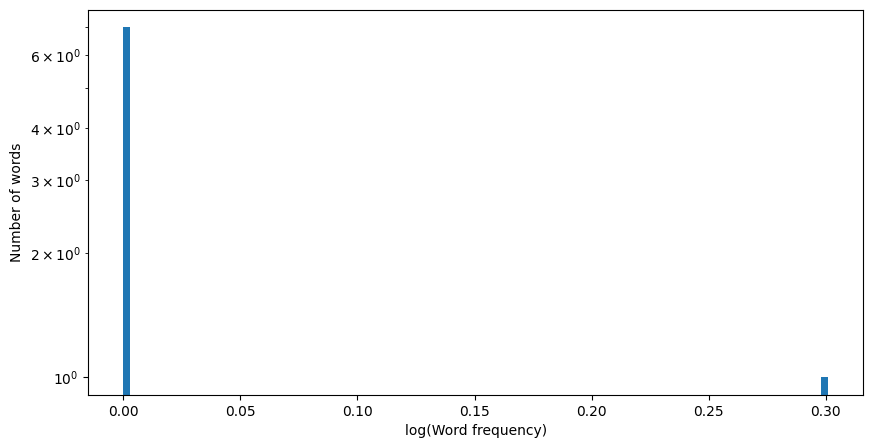

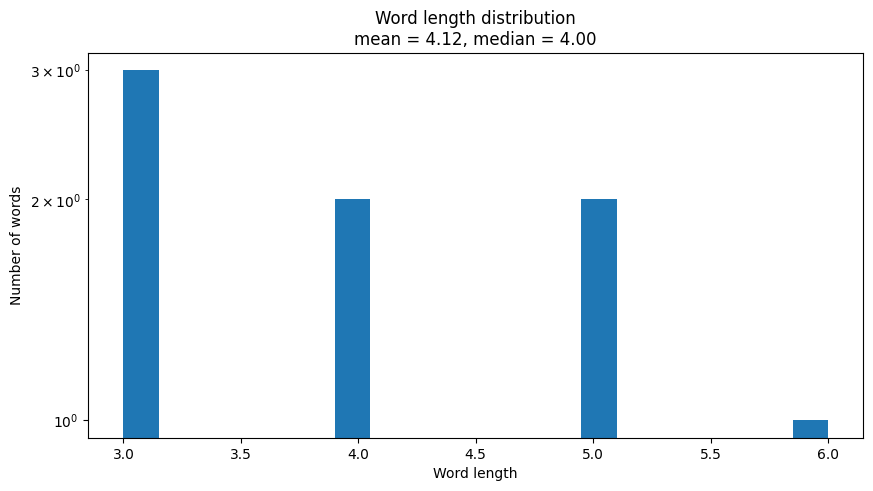

7 words with frequency 1


In [69]:
def tokenize(
	text: str,
	process: bool = False,
) -> list[str]:
	if process:
		text = process_text(text)
	return text.split(' ')

DATA_TOKENIZED: list[str] = tokenize(DATA)

def analyze_vocab(
	tokenized_text: list[str],
) -> Counter[str]:

	vocab_freq: Counter[str] = Counter(tokenized_text)
	vocab_size: int = len(vocab_freq)

	print(f"{vocab_size = }")
	print(f"{vocab_freq.most_common(10) = }")
	print(f"{vocab_freq.most_common()[-10:] = }")

	# get longest and shortest words
	vocab_length_sorted: list[str] = sorted(vocab_freq.keys(), key=len)
	print(f"{vocab_length_sorted[:10] = }")
	print(f"{vocab_length_sorted[-10:] = }")

	# plot histogram of word frequencies
	plt.figure(figsize=(10, 5))
	plt.hist(np.log10(np.array(list(vocab_freq.values()))), bins=100, log=True)
	plt.yscale('log')
	plt.xlabel("log(Word frequency)")
	plt.ylabel("Number of words")
	plt.show()

	# plot histogram of word lengths
	word_lengths = np.array([len(x) for x in vocab_freq.keys()])
	plt.figure(figsize=(10, 5))
	plt.hist(word_lengths, bins=20, log=True)
	plt.yscale('log')
	plt.xlabel("Word length")
	plt.ylabel("Number of words")
	plt.title(f"Word length distribution\nmean = {word_lengths.mean():.2f}, median = {np.median(word_lengths):.2f}")
	plt.show()

	return vocab_freq

VOCAB_FREQ: Counter[str] = analyze_vocab(DATA_TOKENIZED)
WORDS_BY_FREQ: dict[int, list[str]] = {
	freq: [
		word 
		for word, word_freq in VOCAB_FREQ.items() 
		if word_freq == freq
	]
	for freq in set(VOCAB_FREQ.values())
}

for freq in range(1, 2):
	print(f"{len(WORDS_BY_FREQ[freq])} words with frequency {freq}")


In [70]:
# sorted by frequency
VOCAB_ARR: list[str] = [word for word, _ in VOCAB_FREQ.most_common()]
VOCAB_DICT: dict[str, int] = {word: i for i, word in enumerate(VOCAB_ARR)}

def encode(
	text: str|list[str],
) -> Int[np.ndarray, "n_tokens"]:
	if isinstance(text, str):
		text = tokenize(text)
	return np.array([VOCAB_DICT[word] for word in text])

def decode(
	encoded_text: list[int],
) -> str:
	return ' '.join(VOCAB_ARR[i] for i in encoded_text)

DATA_ENCODED: Int[np.ndarray, "n_tokens"] = encode(DATA)

print(f"{DATA_ENCODED[:10] = }")

DATA_ENCODED[:10] = array([0, 1, 2, 3, 4, 5, 0, 6, 7])


In [ ]:
class tokenizer:
    def __init__(self):
        pass

    def tokenize(self,
        text: str,
        process: bool = False,
    ) -> list[str]:
        if process:
            text = process_text(text)
        return text.split(' ')

    def encode(self,
            text: str|list[str],
    ) -> Int[np.ndarray, "n_tokens"]:
            if isinstance(text, str):
                text = tokenize(text)
            return np.array([self.vocab_dict[word] for word in text])

    def decode(self,
        encoded_text: list[int],
    ) -> str:
        return ' '.join(self.vocab_arr[i] for i in encoded_text)

    def process_set_tokenize_text(self, text: str):
        processed_text = self.process_text(text)
        tokenized_text = self.tokenize(processed_text)
        VOCAB_FREQ: Counter[str] = self.analyze_vocab(tokenized_text)
        self.vocab_arr: list[str] = [word for word, _ in VOCAB_FREQ.most_common()]
        self.vocab_dict: dict[str, int] = {word: i for i, word in enumerate(self.vocab_arr)}
        return tokenized_text
        
    def process_text(self,
            text: str,
            allowed_punctuation: str = "-.,;:!?()\"" + "".join(str(x) for x in range(10)),
            punctuation_convert: dict[str,str] = {'—': '-'},
        ) -> str:
            
            # replace some special characters which unicode won't normalize properly
            for char, replacement in punctuation_convert.items():
                text = text.replace(char, replacement)

            # if a line has ".jpg" in it, remove that line (this is specific to Don Quixote)
            text = '\n'.join(
                line 
                for line in text.split('\n')
                if '.jpg' not in line
            )

            # Normalize the string to decompose Unicode characters
            text = unicodedata.normalize('NFKD', text)

            # Encode to ASCII bytes, then decode back to string, ignoring errors
            text = text.encode('ascii', 'ignore').decode('ascii')

            # remove newlines and tabs
            text = text.replace('\n', ' ').replace('\t', ' ')


            # put spaces around allowed punctuation
            for char in allowed_punctuation:
                text = text.replace(char, f' {char} ')


            # remove leading and trailing spaces
            text = text.strip()

            # remove multiple spaces
            while '  ' in text:
                text = text.replace('  ', ' ')


            # remove all characters except (alphanumeric, allowed_punctuation, ' ')
            text = ''.join(
                (
                    char 
                    if (
                        char.isalnum() 
                        or char in allowed_punctuation 
                        or char == ' '
                    )
                    else ' '
                )
                for char in text 
            )

            # convert to lowercase
            text = text.lower()

            text = text.strip()

            return text

    def analyze_vocab(self,
        tokenized_text: list[str],
    ) -> Counter[str]:
        vocab_freq: Counter[str] = Counter(tokenized_text)
        return vocab_freq

            

In [74]:
print(len(VOCAB_ARR))


8


In [71]:
data = [2,5,7,8,9,4,3,2,15,18,12]

In [ ]:
config1 = Config(20, len(VOCAB_ARR), 100)

In [75]:
def map_token(token:int, embedding_matrix):
    return embedding_matrix[token]

In [ ]:
# Embedding = nn.Parameter(torch.Tensor(data))

In [ ]:
for i in DATA_ENCODED:
    map_token(i, )

In [ ]:
# Embedding = nn.Parameter(torch.Tensor(data))

In [30]:
class MLP(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.activation = nn.ReLU()
        self.linear_up: nn.Linear = nn.Linear(config.d_model, config.d_hidden)
        self.hidden_layer: nn.Linear = nn.Linear(config.d_hidden, config.d_hidden)
        self.linear_down: nn.Linear = nn.Linear(config.d_hidden, config.d_model)

    def forward(self, input):
        a = self.activation(self.linear_up(input))
        a = self.activation(self.hidden_layer(a))
        return self.activation(self.linear_down(a))
        

In [31]:
class AttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_model = config.d_model
        self.qk = torch.rand(self.d_model, self.d_model)
        self.ov = torch.rand(self.d_model, self.d_model)


    def forward(self, embedding):
        n_context = embedding.shape[0]
        
        attention = embedding@self.qk@embedding.T
        negatives = torch.ones(n_context, n_context)*torch.inf*-1
        negatives = torch.triu(negatives, diagonal=1)
        attention += negatives

        A = nn.Softmax(attention)@embedding@self.ov
        return A

In [32]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_model = config.d_model
        self.attention_head = AttentionHead(config)
        self.mlp = MLP(config)


    def forward(self, x):
        return x + self.attention_head(x) + self.mlp(x)


In [ ]:
class LLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = torch.nn.Embedding(config.d_vocab, config.d_model)
        self.TB1 = TransformerBlock(config)
        self.TB2 = TransformerBlock(config)
        self.embedding_matrix = torch.Parameter(torch.rand(config.d_vocab, config.d_model))
        self.config = config


    def forward(self, x):
        return self.embedding(self.TB2(self.TB1(self.embedding(x))))
    
    def embed(self, data=DATA_ENCODED):
        x = torch.zeros(len(data), self.config.d_model)
        for i in data:
            x[i,:] = map_token(i, self.embedding_matrix)


In [36]:
llm = LLM(config1)
print(llm(torch.tensor(data)))

TypeError: unsupported operand type(s) for @: 'Softmax' and 'Tensor'